In [1]:
import os
from funman.server.query import FunmanResults
from pathlib import Path
import logging
from IPython.core.display import Image
from IPython.display import display
import glob
import pydantic

# remove matplotlib debugging
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True


# %matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

this_dir = Path.cwd()

test_output_dir=os.path.join(
    this_dir, "../scratch/test/out"
)


if not os.path.exists(test_output_dir):
    assert "Test output does not exist"

Reading output files from /root/funman/notebooks/../scratch/test/out
Results for: a0197fba-8ffd-475d-9328-adb25bc2d306
No True points
Results for: c770e243-e062-449e-8496-1501c1a54aa0
True point:
Parameters: [{'beta': -1.7427679397599346e+308, 'gamma': -9.399396943001306e+306, 'S0': 0.41590809365775616, 'I0': 0.0, 'R0': 0.5850527048192498}]


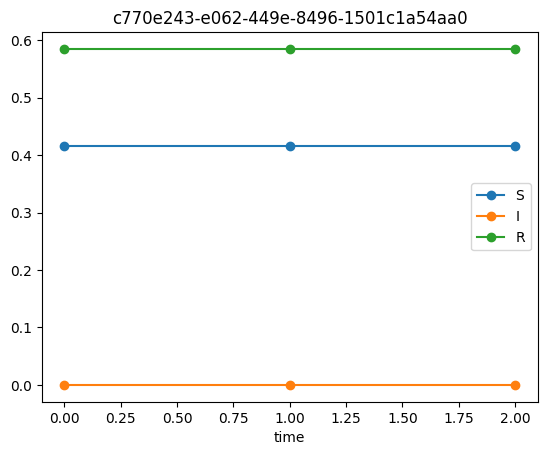

In [5]:
output_files = glob.glob(test_output_dir+"/*.json")
print(f"Reading output files from {test_output_dir}")
for ofile in output_files:
    try:
        result = pydantic.parse_file_as(FunmanResults, ofile)
        print(f"Results for: {result.id}")
        if len(result.parameter_space.true_points) > 0:
            print("True point:")
            parameters = result.model._parameter_names()
            points = result.parameter_space.true_points[0:1]
            point_parameters = [ {param: p.values[param] for param in parameters} for p in points]
            print(f"Parameters: {point_parameters}")
            try:
                result.plot(points, variables=result.model._state_var_names(), title=f"{result.id}")
            except Exception as e1:
                print(f"Could not plot {ofile} resutls: {e1}")
        else:
            print("No True points")
    except Exception as e:
        print(f"Could not open result {ofile}: {e}")

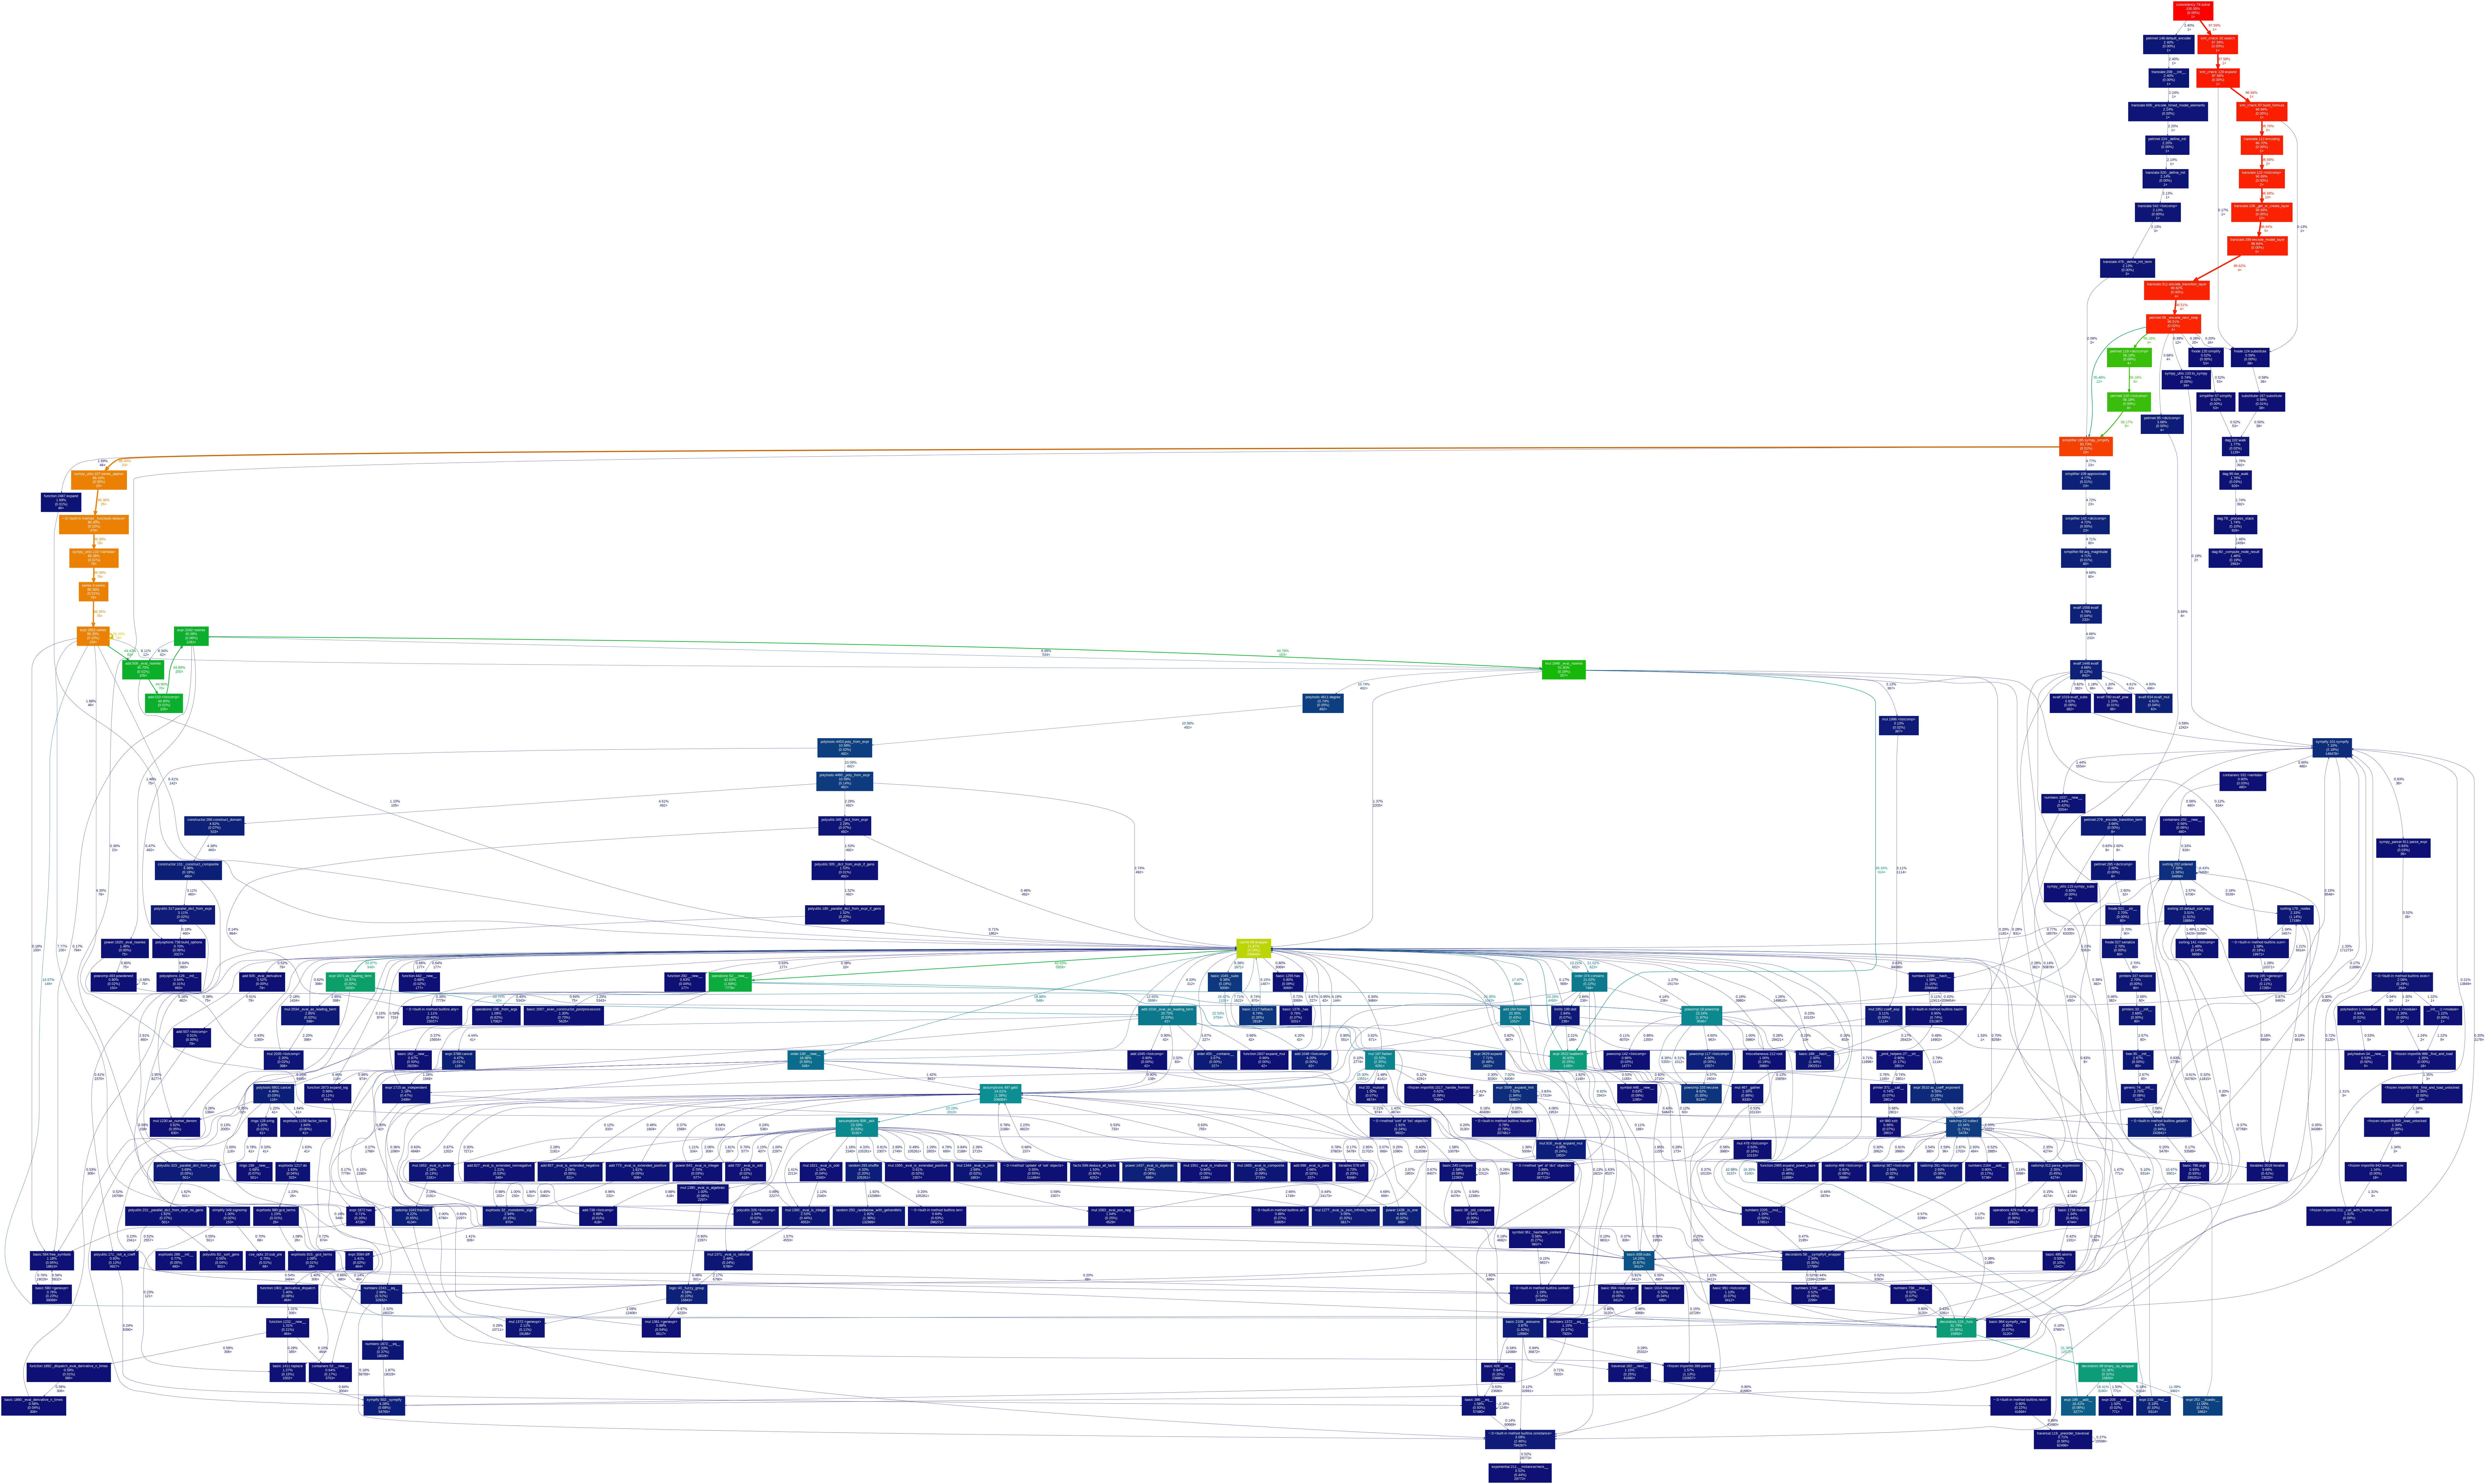

In [12]:
# View profiling if present
profile_file = os.path.join(f"/root/profile.stats")
if os.path.exists(profile_file):
    os.system(f"gprof2dot -f pstats {profile_file} | dot -Tpng -o profile.png")
    display(Image(filename='profile.png'))
else:
    print(f"{profile_file} file not present")

INFO:funman.server.worker:FunmanWorker running...
INFO:funman.server.worker:Starting work on: f48fd935-1054-4ce9-8bfe-ac82bc76c639
INFO:funman.server.worker:Completed work on: f48fd935-1054-4ce9-8bfe-ac82bc76c639
INFO:funman.server.worker:FunmanWorker exiting...
[{'N': 19340000.0, 'beta': 0.5, 'r_E_to_I': 0.5, 'p_I_to_R': 0.5, 'r_I_to_R': 0.5, 'p_I_to_H': 0.5, 'r_I_to_H': 0.5, 'p_H_to_R': 0.5, 'r_H_to_R': 0.5, 'p_H_to_D': 0.5, 'r_H_to_D': 0.5}]


<Axes: xlabel='time'>

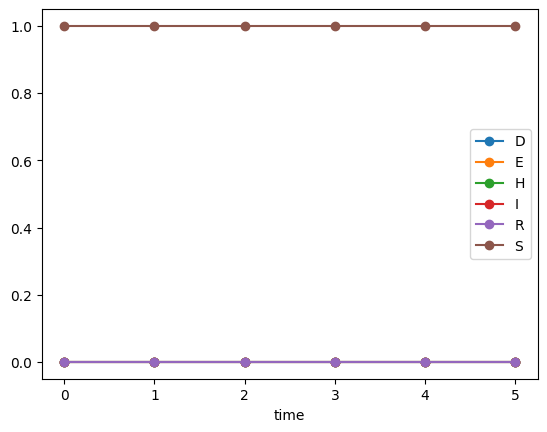

In [12]:
# Relax the parameters to see if an alternative parameterization would work.
model = base_model
request = base_request.copy()
request["parameters"] = [
    {
        "name": param,
        "label": "any",
        "lb": 0.0,
        "ub": 1.0
    } for param in parameters if param != "N"
]
request["config"]["profile"] = True
# request["config"]["substitute_subformulas"] = True
# request["config"]["simplify_query"] = True

# Restrict attention to area where the important behavior occurs
num_steps_param = next(p for p in request["structure_parameters"] if p["name"] == "num_steps")
num_steps_param["lb"]= 5
num_steps_param["ub"]= 5

result = Runner().run(model, request, case_out_dir=out_dir)
points = result.parameter_space.true_points[0:1]
point_parameters = [ {param: p.values[param] for param in parameters} for p in points]
print(point_parameters)

result.plot(points, variables=["D", "E", "H", "I", "R", "S"])


In [ ]:

os.system(f"gprof2dot -f pstats {this_dir}/profile.stats | dot -Tpng -o profile.png")
display(Image(filename='profile.png'))